In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import optuna


import warnings
warnings.filterwarnings('ignore')

In [383]:
data = pd.read_csv('datasets/ufc-master.csv')

Удаляем строки, где бой завершился дисквалификацией или `No contest`

In [384]:
mask = ~data['Finish'].isin(['DQ', 'Overturned'])
data = data[mask] # удалили 20 строк

In [385]:
data['Finish'].value_counts()

Finish
U-DEC     2404
KO/TKO    2009
SUB       1157
S-DEC      654
M-DEC       46
Name: count, dtype: int64

Удаляем ненужные признаки

In [386]:
valuable_features = ['RedFighter',
                     'BlueFighter',                  
                     'WeightClass',
                     'Gender',
                     'Winner',
                     'Finish',
                     'NumberOfRounds',
                     'RedAge',
                     'RedHeightCms',
                     'RedReachCms',
                     'RedWeightLbs',
                     'RedStance',
                     'RedWins',
                     'RedWinsByDecisionMajority',
                     'RedWinsByDecisionSplit',
                     'RedWinsByDecisionUnanimous',
                     'RedWinsByKO',
                     'RedWinsByTKODoctorStoppage',
                     'RedWinsBySubmission',
                     'RedCurrentWinStreak',
                     'RedLosses',
                     'RedCurrentLoseStreak',
                     'RedAvgSigStrLanded',
                     'RedAvgSigStrPct',                     
                     'RedAvgSubAtt',
                     'RedAvgTDLanded',
                     'RedAvgTDPct',
                     'RedTotalRoundsFought',
                     'BlueAge',
                     'BlueHeightCms',
                     'BlueReachCms',
                     'BlueWeightLbs',
                     'BlueStance',
                     'BlueWins',
                     'BlueWinsByDecisionMajority',
                     'BlueWinsByDecisionSplit',
                     'BlueWinsByDecisionUnanimous',
                     'BlueWinsByKO',
                     'BlueWinsByTKODoctorStoppage',
                     'BlueWinsBySubmission',
                     'BlueCurrentWinStreak',
                     'BlueLosses', 
                     'BlueCurrentLoseStreak',                    
                     'BlueAvgSigStrLanded',                 # Среднее количество значимых ударов, выбрасываемых в минуту синим бойцом
                     'BlueAvgSigStrPct',                    # Соотношение значимых попаданий к общему количеству значимых ударов для синего бойца   
                     'BlueAvgSubAtt',                       # Среднее количесвто попыток болевого приема за 15 минут для синего бойца
                     'BlueAvgTDLanded',                     # Среднее количесвто тейкдаунов за 15 минут для синего бойца
                     'BlueAvgTDPct',                        # Соотношение успешных тейкдаунов к общему количеству попыток для синего бойца
                     'BlueTotalRoundsFought'
                    ]

data = data[valuable_features]

Объединяем признаки `Winner` и `Finish` в один признак `Result`

In [387]:
def def_target(row):
    if row['Winner'] == 'Red':
        if row['Finish'] == 'KO/TKO':
            return 'Red-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Red-Submission'
        else:
            return 'Red-Decision'
    if row['Winner'] == 'Blue':
        if row['Finish'] == 'KO/TKO':
            return 'Blue-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Blue-Submission'
        else:
            return 'Blue-Decision'
        
data['Result'] = data.apply(def_target, axis=1)

Объединим несколько признаков между собой для того, чтобы уменьшить количество признаков

In [388]:
data['RedWinsByDecision'] = data['RedWinsByDecisionMajority'] + data['RedWinsByDecisionSplit'] + data['RedWinsByDecisionUnanimous']
data['RedWinsByKO/TKO'] = data['RedWinsByKO'] + data['RedWinsByTKODoctorStoppage']

data['BlueWinsByDecision'] = data['BlueWinsByDecisionMajority'] + data['BlueWinsByDecisionSplit'] + data['BlueWinsByDecisionUnanimous']
data['BlueWinsByKO/TKO'] = data['BlueWinsByKO'] + data['BlueWinsByTKODoctorStoppage']

# Удалим лишние признаки
columns_to_drop = ['RedWinsByDecisionMajority',
                   'RedWinsByDecisionSplit',
                   'RedWinsByDecisionUnanimous',
                   'RedWinsByKO',
                   'RedWinsByTKODoctorStoppage',
                   'BlueWinsByDecisionMajority',
                   'BlueWinsByDecisionSplit',
                   'BlueWinsByDecisionUnanimous',
                   'BlueWinsByKO',
                   'BlueWinsByTKODoctorStoppage',
                   'Winner',
                   'Finish'
                   #'RedWeightLbs',
                   #'BlueWeightLbs'                          
                    ]

data = data.drop(columns=columns_to_drop, axis=1)

Бинарные и ориднильные признаки можно преобразовать в числовой вид 

In [389]:
binary_features = ['Gender', 'NumberOfRounds', 'RedStance', 'BlueStance']
data['Gender'] = data['Gender'].map({'FEMALE': 0, 'MALE': 1})
data['NumberOfRounds'] = data['NumberOfRounds'].map({3: 0, 5: 1})
data['RedStance'] = data['RedStance'].map({'Southpaw': 0, 'Orthodox': 1})
data['BlueStance'] = data['BlueStance'].map({'Southpaw': 0, 'Orthodox': 1})

ordinal_features = ['WeightClass', 'Result']
data['WeightClass'] = data['WeightClass'].map({"Women's Strawweight": 0,
                                               'Flyweight': 0,
                                               "Women's Flyweight": 0,
                                               'Bantamweight': 1,
                                               "Women's Bantamweight": 1,
                                               'Featherweight': 2,
                                               "Women's Featherweight": 2,
                                               'Catch Weight': 2,
                                               'Lightweight': 3,
                                               'Welterweight': 4,
                                               'Middleweight': 5,
                                               'Light Heavyweight': 6,
                                               'Heavyweight': 7})

data['Result'] = data['Result'].map({'Red-KO/TKO': 0,
                                     'Red-Submission': 1,
                                     'Red-Decision': 2,
                                     'Blue-KO/TKO': 3,
                                     'Blue-Submission' : 4,
                                     'Blue-Decision': 5                                     
                                    })

Бинаризуем `Result`

In [390]:
data['Result'] = data['Result'].isin([1, 3, 5]).astype(int)

Проверяем наличие пропусков

In [391]:
def check_columns_with_nans(df):
    flag = 0
    for col in df.columns:
        isna_sum = 0
        if df[col].isna().any():
            flag = 1 
            isna_sum = df[col].isna().sum()
            print(f'Количество пропусков в столбце {col}: {isna_sum}')
    if not flag:
        print('Пропусков в данных не обнаружено')

check_columns_with_nans(data)

Количество пропусков в столбце NumberOfRounds: 21
Количество пропусков в столбце RedStance: 374
Количество пропусков в столбце RedAvgSigStrLanded: 453
Количество пропусков в столбце RedAvgSigStrPct: 355
Количество пропусков в столбце RedAvgSubAtt: 355
Количество пропусков в столбце RedAvgTDLanded: 355
Количество пропусков в столбце RedAvgTDPct: 365
Количество пропусков в столбце BlueStance: 409
Количество пропусков в столбце BlueAvgSigStrLanded: 926
Количество пропусков в столбце BlueAvgSigStrPct: 761
Количество пропусков в столбце BlueAvgSubAtt: 828
Количество пропусков в столбце BlueAvgTDLanded: 829
Количество пропусков в столбце BlueAvgTDPct: 838


Заполняем очевидные пропуски (там, где не нужно поднимать статистику, чтобы их заполнить)

In [392]:
data['NumberOfRounds'] = data['NumberOfRounds'].fillna(0)
data['RedStance'] = data['RedStance'].fillna(1)
data['BlueStance'] = data['BlueStance'].fillna(1)

Исправляем ошибки в статистических данных

In [393]:
stats_columns = ['RedAvgSigStrLanded',
                'BlueAvgSigStrLanded',
                'RedAvgSigStrPct',
                'BlueAvgSigStrPct',
                'RedAvgSubAtt',
                'BlueAvgSubAtt',
                'RedAvgTDLanded',
                'BlueAvgTDLanded',
                'RedAvgTDPct',
                'BlueAvgTDPct'
                ]   

def stats_columns_hist(df, columns):
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 19))
    for i in range(len(columns)):
        axs[int(i // 2), i % 2].hist(df[columns[i]], bins=30)
        axs[int(i // 2), i % 2].set_title(columns[i])
        axs[int(i // 2), i % 2].grid()

# stats_columns_hist(data, stats_columns)

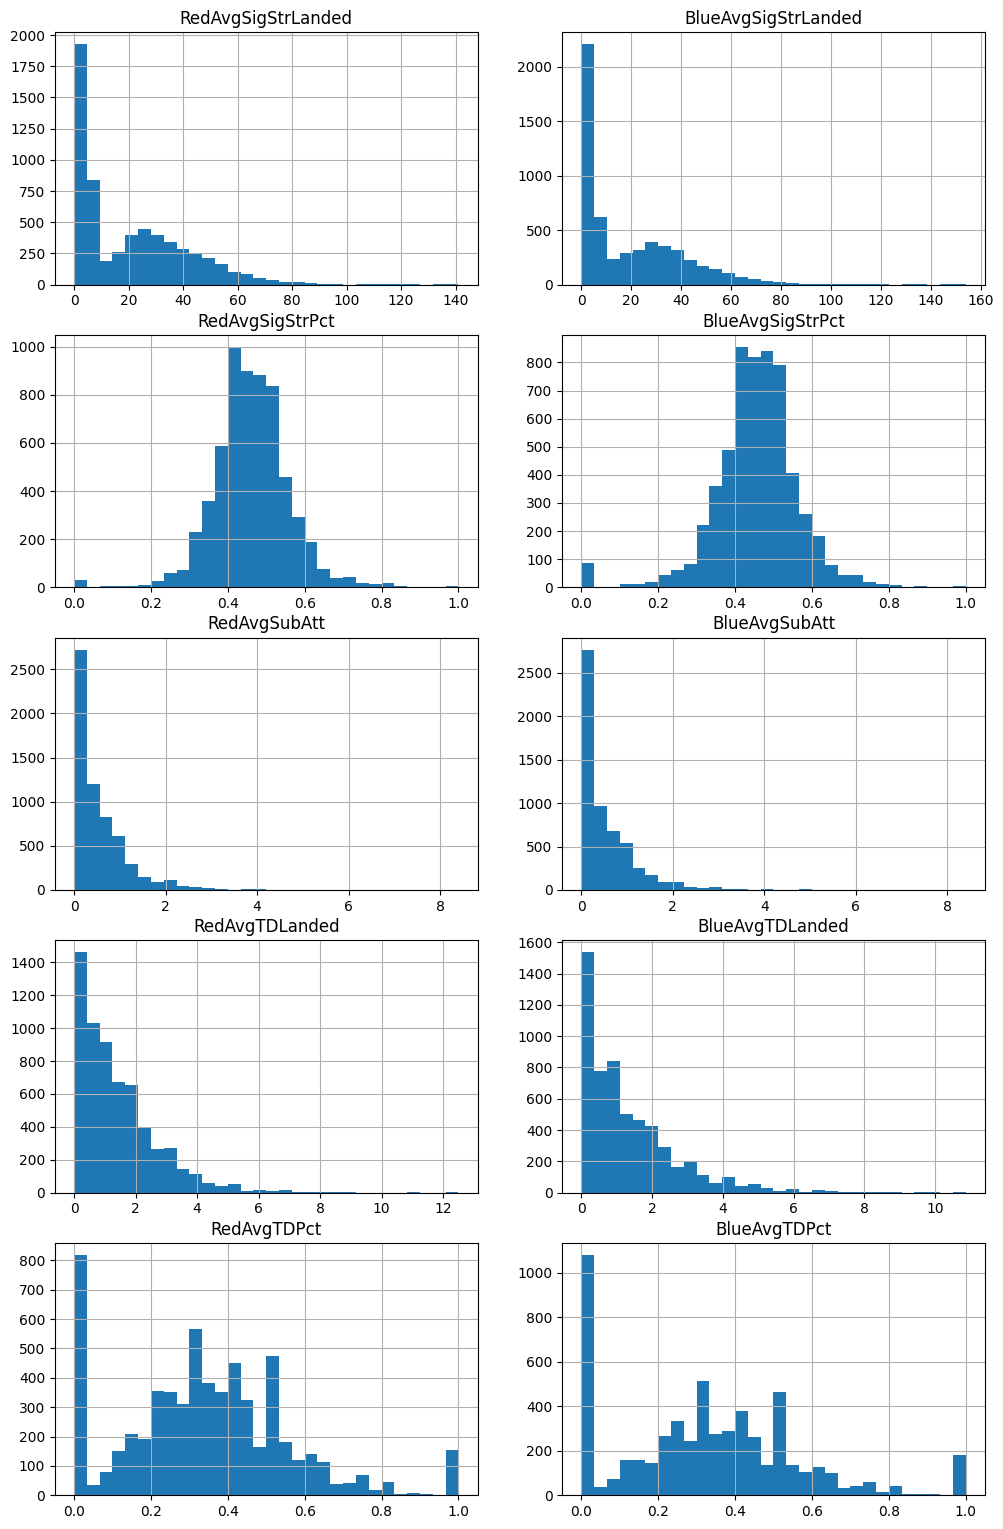

In [394]:
stats_columns_hist(data, stats_columns)

### Заполняем пропуски в статистических признаках

In [395]:
check_columns_with_nans(data)

Количество пропусков в столбце RedAvgSigStrLanded: 453
Количество пропусков в столбце RedAvgSigStrPct: 355
Количество пропусков в столбце RedAvgSubAtt: 355
Количество пропусков в столбце RedAvgTDLanded: 355
Количество пропусков в столбце RedAvgTDPct: 365
Количество пропусков в столбце BlueAvgSigStrLanded: 926
Количество пропусков в столбце BlueAvgSigStrPct: 761
Количество пропусков в столбце BlueAvgSubAtt: 828
Количество пропусков в столбце BlueAvgTDLanded: 829
Количество пропусков в столбце BlueAvgTDPct: 838


In [396]:
# Выберем дебютантов среди RedFighter
red_stats_cols = [col for col in stats_columns if col.find('Red') > -1]
blue_stats_cols = [col for col in stats_columns if col.find('Blue') > -1]

# Поскольку у дебютантов еще нет статистики (или, во всяком случае, не должно быть), заменяем все NaN нулями
data.loc[data['RedTotalRoundsFought'] == 0, red_stats_cols] = 0
data.loc[data['BlueTotalRoundsFought'] == 0, blue_stats_cols] = 0

In [397]:
red_cols = [col for col in data.columns if col.find('Red') > -1]
blue_cols = [col for col in data.columns if col.find('Blue') > -1]

# Проверим, сколько осталось бойцов-недебютантов с пропусками в статистике по ударам 
print(len(data[data['RedAvgSigStrLanded'].isna()][red_cols]))
print(len(data[data['BlueAvgSigStrLanded'].isna()][blue_cols]))

86
90


### Исправление данных по статистикам бойцов

In [398]:
# Cоберем реальную статистику по значимым ударам для каждого бойца
fighters_strikes = {}

# Проходим по датафрейму и собираем информацию по бойцам в красном углу
for index, row in data.iterrows():
    fighter = row['RedFighter']
    strikes = row['RedAvgSigStrLanded']

    # Для каждого бойца составляем список со всеми адекватными значениями количества ударов
    if 0 < strikes < 10 and pd.notna(strikes):   
        if fighter in fighters_strikes:
            fighters_strikes [fighter].append(strikes)
        else:
            fighters_strikes [fighter] = [strikes]

# Проходим по датафрейму и собираем информацию по бойцам в синем углу
for index, row in data.iterrows():
    fighter = row['BlueFighter']
    strikes = row['BlueAvgSigStrLanded']

    if 0 < strikes < 10 and pd.notna(strikes): 
        if fighter in fighters_strikes:
            fighters_strikes [fighter].append(strikes)
        else:
            fighters_strikes [fighter] = [strikes]

# Усредняем показатель по количеству ударов для каждого бойца
for k, v in fighters_strikes.items():
    fighters_strikes[k] = np.round(np.mean(np.array(v)), 2)

In [399]:
# Пройдемся среди недебютантов, поскольку тех мы уже обработали
for index, row in data.loc[data['RedTotalRoundsFought'] > 0, :].iterrows():
    # Для всех аномальных значений заменяем их на усредненное значение конкретно для этого бойца, взятое из словаря
    if pd.isna(row['RedAvgSigStrLanded']) or row['RedAvgSigStrLanded'] >= 10:
        if row['RedFighter'] in fighters_strikes:
            data.loc[index, 'RedAvgSigStrLanded'] = fighters_strikes[row['RedFighter']]

for index, row in data.loc[data['BlueTotalRoundsFought'] > 0, :].iterrows():        
    if pd.isna(row['BlueAvgSigStrLanded']) or row['BlueAvgSigStrLanded'] >= 10:
        # Для всех аномальных значений заменяем их на усредненное значение конкретно для этого бойца, взятое из словаря
        if row['BlueFighter'] in fighters_strikes:
            data.loc[index, 'BlueAvgSigStrLanded'] = fighters_strikes[row['BlueFighter']]

In [400]:
# Удаляем все остальные пропуски
check_columns_with_nans(data)
data = data.dropna()

Количество пропусков в столбце RedAvgSigStrLanded: 8
Количество пропусков в столбце RedAvgTDPct: 7
Количество пропусков в столбце BlueAvgSigStrLanded: 7
Количество пропусков в столбце BlueAvgTDLanded: 1
Количество пропусков в столбце BlueAvgTDPct: 9


In [401]:
data[data['BlueFighter'] == 'Petr Yan']['BlueAvgSigStrLanded']
data[data['RedFighter'] == 'Marlon Moraes']['RedAvgSigStrLanded']

1413    3.37
1648    3.34
2007    0.00
2107    3.53
2471    3.41
3454    3.41
Name: RedAvgSigStrLanded, dtype: float64

Проверим, по какому количеству бойцов исправить статистику по ударам не удалось из-за полного отсутствия адекватных данных по этим бойцам

In [402]:
print(data.loc[(data['RedTotalRoundsFought'] > 0) &  (data['RedAvgSigStrLanded'] == 0), red_cols]['RedFighter'].count())
print(data.loc[(data['BlueTotalRoundsFought'] > 0) &  (data['BlueAvgSigStrLanded'] == 0), blue_cols]['BlueFighter'].count())

12
16


In [403]:
# # Добавим порядковый номер боя, чтобы не сбиться
# data['FightNumber'] = np.arange(len(data))

# # Определяем аномалии по заданной эвристике
# red_anomaly_mask = data['RedAvgSigStrLanded'] >= 10
# blue_anomaly_mask = data['BlueAvgSigStrLanded'] >= 10

# # Функция для замены аномальных цен на ближайшую реальную
# def replace_anomalies(group, column):
#     # Удаляем аномалии
#     clean_group = group[group[column] < 10]
    
#     # Если группа не пуста, заменяем аномалии на ближайшую реальную цену
#     if not clean_group.empty:
#         nearest_value = clean_group[column].iloc[-1]  # Берем последнюю реальную цену
        
#         # Заменяем аномалии на ближайшую реальную цену
#         group.loc[group[column] >= 10, column] = nearest_value
#         group.loc[group[column].isna(), column] = nearest_value
        
#     return group

# # Заменяем аномалии для каждого бойца
# temp = data.groupby('RedFighter').apply(replace_anomalies, column='RedAvgSigStrLanded')
# temp = temp.drop('RedFighter', axis=1).reset_index()
# temp = temp.sort_values(by='level_1')
# temp = temp.groupby('BlueFighter').apply(replace_anomalies, column='BlueAvgSigStrLanded')
# temp = temp.drop(['BlueFighter', 'level_1'], axis=1).reset_index()
# data = temp.drop('level_1', axis=1).sort_values(by='FightNumber')
# data.set_index('FightNumber', inplace=True)
# data

Проверим, сколько строчек до сих пор содержат аномальные значения по статистике ударов

In [404]:
# data_final = data[(data['RedAvgSigStrLanded'] < 10) & (data['BlueAvgSigStrLanded'] < 10)]
data[(data['RedAvgSigStrLanded'] >= 10) | (data['BlueAvgSigStrLanded'] >= 10)][['RedFighter', 
                                                                               'BlueFighter',
                                                                               'RedAvgSigStrLanded',
                                                                               'BlueAvgSigStrLanded',
                                                                               'WeightClass']]

,RedFighter,BlueFighter,RedAvgSigStrLanded,BlueAvgSigStrLanded,WeightClass
260,Carli Judice,Gabriella Fernandes,11.2300,3.7300,0
2744,Tatiana Suarez,Nina Ansaroff,4.2700,75.1667,0
2753,Jimi Manuwa,Aleksandar Rakic,26.0909,4.4200,6
2756,Daniel Teymur,Sung Bin Jo,41.0000,0.0000,2
2758,Tonya Evinger,Lina Lansberg,20.5000,2.7100,1
...,...,...,...,...,...
6523,Duane Ludwig,Darren Elkins,13.6667,0.0000,3
6524,John Howard,Daniel Roberts,18.0000,0.0000,4
6525,Brendan Schaub,Chase Gormley,12.0000,8.0000,7
6526,Mike Pierce,Julio Paulino,40.5000,0.0000,4


In [405]:
# Удалим эти аномальные строки
data_final = data[(data['RedAvgSigStrLanded'] < 10) & (data['BlueAvgSigStrLanded'] < 10)]

In [406]:
# # Функция поиска выбросов и замены их на медиану
# def replace_outliers(series):
#     Q1 = series.quantile(0.25)
#     Q3 = series.quantile(0.75)
#     IQR = Q3 - Q1
    
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     median = series.median()
    
#     series.loc[(series > upper_bound)] = median
#     print(f'q25: {Q1}, q75: {Q3}, IQR: {IQR}, upper bound: {upper_bound}, median: {median}')
#     return series

# # Для каждой весовой категории ищем свою медиану и заменяем выбросы на нее
# for col in ['RedAvgSigStrLanded', 'BlueAvgSigStrLanded']:
#     print(data.loc[:, col].median())
#     data.loc[:, col] = replace_outliers(data.loc[:, col])

In [407]:
data_final

,RedFighter,BlueFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
0,Alexandre Pantoja,Kai Asakura,0,1,1.0,34,165.10,170.18,125,1.0,...,0.000,0.0000,0.0000,0.000,0,1,6,2,0,0
1,Shavkat Rakhmonov,Ian Machado Garry,4,1,0.0,30,185.42,195.58,170,1.0,...,0.550,0.3000,0.7700,0.550,20,0,0,1,5,3
2,Ciryl Gane,Alexander Volkov,7,1,0.0,34,193.04,205.74,245,1.0,...,0.570,0.2000,0.4500,0.630,44,0,3,4,5,6
3,Bryce Mitchell,Kron Gracie,2,1,0.0,30,177.80,177.80,145,0.0,...,0.440,0.5000,0.4700,0.250,7,0,6,0,0,0
4,Nate Landwehr,Dooho Choi,2,1,0.0,36,175.26,182.88,145,1.0,...,0.530,0.8000,0.7500,0.370,15,1,2,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6486,Anderson Silva,Demian Maia,5,1,1.0,34,187.96,195.58,185,0.0,...,0.491,1.2857,1.5714,0.420,12,0,1,7,1,0
6497,Roy Nelson,Stefan Struve,7,1,0.0,33,182.88,182.88,263,1.0,...,0.468,3.0000,0.5000,0.500,7,0,0,1,1,0
6506,Charlie Brenneman,Jason High,4,1,0.0,29,177.80,182.88,155,1.0,...,0.000,0.0000,0.0000,0.000,0,0,0,0,0,0
6508,Frank Mir,Shane Carwin,7,1,1.0,30,190.50,200.66,264,0.0,...,0.437,0.0000,0.3333,0.167,3,1,1,2,0,3


Финальная проверка на пропуски и наличие аномалий

In [408]:
check_columns_with_nans(data_final)

Пропусков в данных не обнаружено


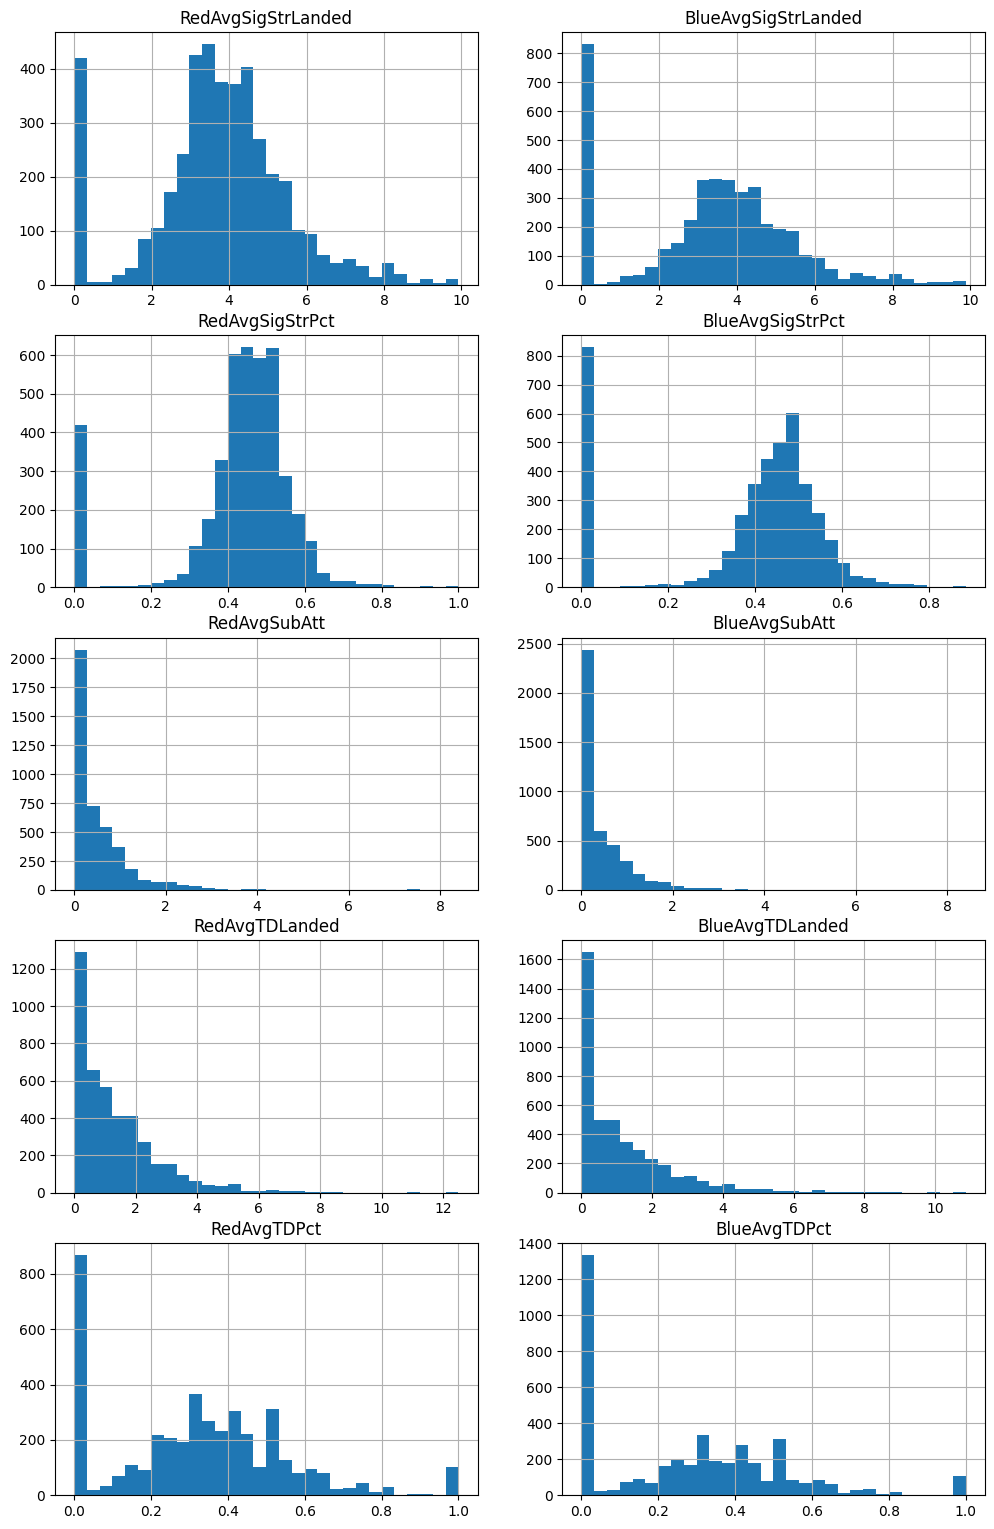

In [409]:
stats_columns_hist(data_final, stats_columns)

### Разбиваем данные на трейн и тест

Удалим всех бойцов, у которых есть 0 в статистических показателях

In [417]:
# Определите столбцы, которые должны быть ненулевыми
columns_to_check = ['RedAvgSigStrLanded', 'BlueAvgSigStrLanded']

# Создайте маску для фильтрации строк
mask = ~data_final[columns_to_check].eq(0).any(axis=1)

# Примените маску для фильтрации датафрейма
data_final = data_final.loc[mask]
data_final

,RedFighter,BlueFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
1,Shavkat Rakhmonov,Ian Machado Garry,4,1,0.0,30,185.42,195.58,170,1.0,...,0.550,0.3000,0.7700,0.550,20,0,0,1,5,3
2,Ciryl Gane,Alexander Volkov,7,1,0.0,34,193.04,205.74,245,1.0,...,0.570,0.2000,0.4500,0.630,44,0,3,4,5,6
3,Bryce Mitchell,Kron Gracie,2,1,0.0,30,177.80,177.80,145,0.0,...,0.440,0.5000,0.4700,0.250,7,0,6,0,0,0
4,Nate Landwehr,Dooho Choi,2,1,0.0,36,175.26,182.88,145,1.0,...,0.530,0.8000,0.7500,0.370,15,1,2,1,0,4
5,Dominick Reyes,Anthony Smith,6,1,0.0,34,193.04,195.58,205,0.0,...,0.490,0.6000,0.4600,0.260,63,0,2,4,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6485,Jason MacDonald,John Salter,5,1,0.0,34,190.50,203.20,185,1.0,...,0.090,0.0000,1.0000,0.250,3,1,0,2,0,0
6486,Anderson Silva,Demian Maia,5,1,1.0,34,187.96,195.58,185,0.0,...,0.491,1.2857,1.5714,0.420,12,0,1,7,1,0
6497,Roy Nelson,Stefan Struve,7,1,0.0,33,182.88,182.88,263,1.0,...,0.468,3.0000,0.5000,0.500,7,0,0,1,1,0
6508,Frank Mir,Shane Carwin,7,1,1.0,30,190.50,200.66,264,0.0,...,0.437,0.0000,0.3333,0.167,3,1,1,2,0,3


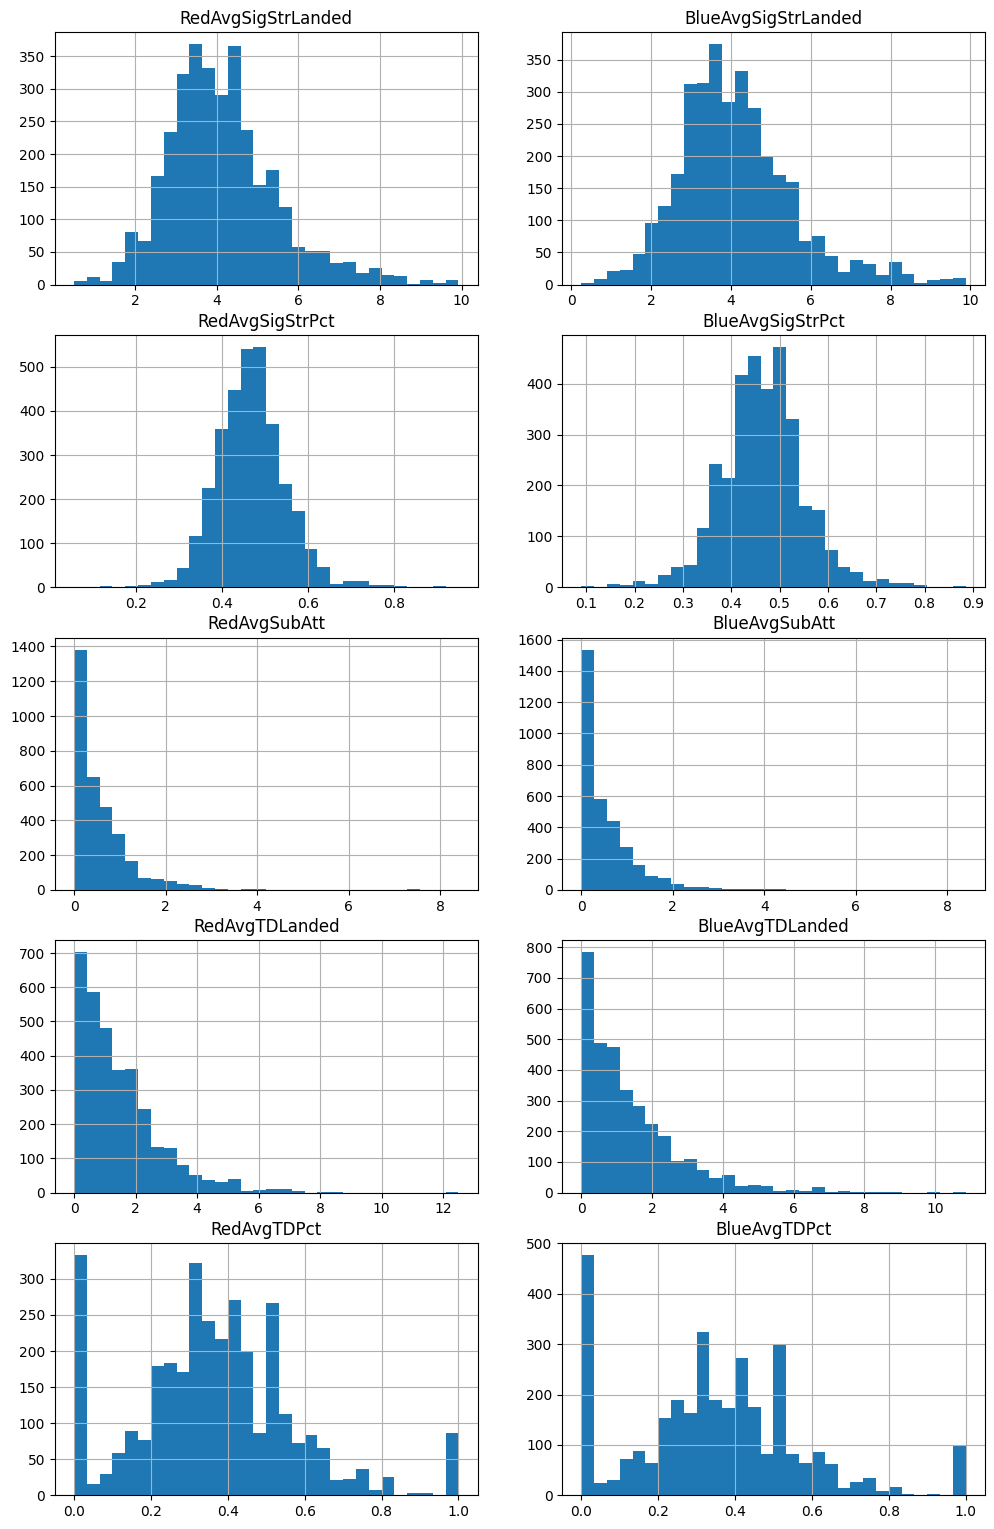

In [419]:
stats_columns_hist(data_final, stats_columns)

In [422]:
data_to_export = data_final.drop(columns=['RedFighter', 'BlueFighter' ], axis=1).to_csv('data_4235_except_zeros.csv')

X = data_final.drop(columns=['Result','RedFighter', 'BlueFighter' ], axis=1)
y = data_final['Result']


test_size = int(len(X)*0.2)

X_train = X.loc[test_size:, :]
y_train = y.loc[test_size:]

X_test = X.loc[:test_size, :]
y_test = y.loc[:test_size]

In [423]:
X_test

,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,RedWins,RedWinsBySubmission,...,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
1,4,1,0.0,30,185.42,195.58,170,1.0,6,5,...,5.50,0.55,0.3,0.77,0.55,20,0,1,5,3
2,7,1,0.0,34,193.04,205.74,245,1.0,9,2,...,5.13,0.57,0.2,0.45,0.63,44,3,4,5,6
3,2,1,0.0,30,177.80,177.80,145,0.0,7,1,...,3.74,0.44,0.5,0.47,0.25,7,6,0,0,0
4,2,1,0.0,36,175.26,182.88,145,1.0,5,2,...,4.41,0.53,0.8,0.75,0.37,15,2,1,0,4
5,6,1,0.0,34,193.04,195.58,205,0.0,7,1,...,3.24,0.49,0.6,0.46,0.26,63,2,4,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,4,1,0.0,33,182.88,180.34,170,1.0,4,0,...,7.29,0.49,0.0,0.00,0.00,3,1,3,0,0
653,4,1,0.0,25,177.80,182.88,170,1.0,1,0,...,4.65,0.50,0.0,0.00,0.00,4,0,1,0,1
654,0,0,0.0,27,165.10,170.18,125,1.0,0,0,...,3.88,0.46,0.0,0.66,0.23,34,0,0,7,0
655,2,1,0.0,30,182.88,187.96,145,1.0,3,0,...,3.29,0.44,0.3,0.00,0.00,3,2,1,0,0


### Обучаем модель

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&M

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       314
           1       0.62      0.58      0.60       288

    accuracy                           0.63       602
   macro avg       0.63      0.63      0.63       602
weighted avg       0.63      0.63      0.63       602



Text(0.5, 23.52222222222222, 'predicted value')

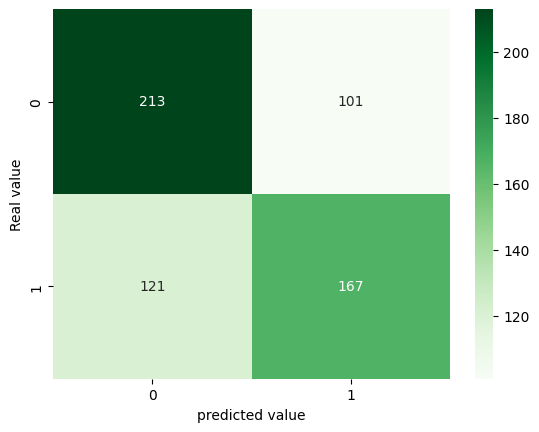

In [424]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('logreg', LogisticRegression(max_iter=1000))
                     ])

params = {'logreg__penalty': [None, 'l1', 'l2'],
          'logreg__C': np.linspace(0.001, 10000, 24),
          'logreg__solver': ['liblinear', 'lbfgs', 'newton-cs'],
          'logreg__class_weight': ['none', 'balanced'],
          'logreg__fit_intercept': [True, False]}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

gs_binary = GridSearchCV(estimator=pipeline, param_grid=params, cv=folds, scoring='f1', verbose=True, n_jobs=-1)

# Обучаем pipeline на тренировочных данных
gs_binary.fit(X_train, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_binary.predict(X_test)

# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [359]:
def optimize_and_train(X_train, y_train, X_test, y_test, n_trials=20):
    # Определение пайплайна
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('logreg', LogisticRegression(max_iter=1000))
    ])

    # Определение кросс-валидации
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

    # Функция для оценки модели
    def objective(trial):
        # Определение пространства поиска гиперпараметров
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        C = trial.suggest_loguniform('C', 0.001, 10000)
        solver = trial.suggest_categorical('solver', ['liblinear'])
        class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
        fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
        
        # Установка гиперпараметров
        pipeline.set_params(
            logreg__penalty=penalty,
            logreg__C=C,
            logreg__solver=solver,
            logreg__class_weight=class_weight,
            logreg__fit_intercept=fit_intercept
        )
        
        # Кросс-валидация
        scores = cross_val_score(pipeline, X_train, y_train, cv=folds, scoring='f1')
        return scores.mean()

    # Создание и запуск оптимизатора
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Лучшие гиперпараметры
    best_params = study.best_params
    print("Best parameters:", best_params)

    # Обучаем пайплайн с лучшими гиперпараметрами
    pipeline.set_params(
        logreg__penalty=best_params['penalty'],
        logreg__C=best_params['C'],
        logreg__solver=best_params['solver'],
        logreg__class_weight=best_params['class_weight'],
        logreg__fit_intercept=best_params['fit_intercept']
    )
    pipeline.fit(X_train, y_train)

    # Делаем прогнозы на тестовых данных
    y_pred = pipeline.predict(X_test)

    # Определяем вероятности
    y_proba = pipeline.predict_proba(X_test)

    # Выводим метрики качества модели
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Матрица ошибок
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Greens')
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.show()

    return pipeline, y_pred, y_proba, pipeline

In [ ]:
pipeline, y_pred, y_proba, model = optimize_and_train(X_train, y_train, X_test, y_test, n_trials=25)

In [425]:
# # Предсказание вероятностей
y_proba = gs_binary.predict_proba(X_test)

# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': data['RedFighter'].iloc[:test_size],
    'BlueFighter': data['BlueFighter'].iloc[:test_size],
    'ProbabilityRedWins': y_proba [:, 0],
    'ProbabilityBlueWins': y_proba [:, 1],
    'ActualWinner': data['Result'].iloc[:test_size]
})


# Калибровочная кривая
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Эмпирическая вероятность')
plt.title('График калибровки логистической регрессии')
plt.legend()

ValueError: array length 602 does not match index length 656

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.52      0.60       314
           1       0.59      0.76      0.67       288

    accuracy                           0.64       602
   macro avg       0.65      0.64      0.63       602
weighted avg       0.65      0.64      0.63       602



Text(0.5, 23.52222222222222, 'predicted value')

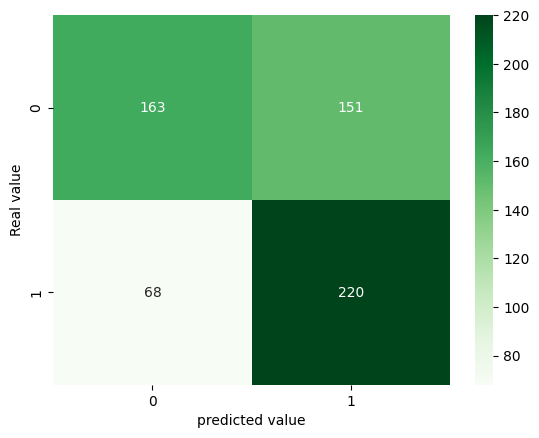

In [426]:
from sklearn.calibration import CalibratedClassifierCV

model = gs_binary.best_estimator_
# Предсказываем вероятности
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
calibrated_model.fit(X_test, y_test)
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test)[:, 1]
# # Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, calibrated_proba, n_bins=10, strategy="uniform")

y_pred_calibrated = calibrated_model.predict(X_test)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_calibrated),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### Feature Engineering

In [427]:
# Создаем новые признаки
def create_new_features(df): 
    df_copy = df.copy()   
    df_copy['Age_diff'] = df_copy['RedAge'] - df_copy['BlueAge']
    df_copy['Height_diff'] = df_copy['RedHeightCms'] - df_copy['BlueHeightCms']
    df_copy['Reach_diff'] = df_copy['RedReachCms'] - df_copy['BlueReachCms']
    df_copy['Weight_diff'] = df_copy['RedWeightLbs'] - df_copy['BlueWeightLbs']
    df_copy['Red_wins_loss_diff'] = df_copy['RedWins'] - df_copy['RedLosses']
    df_copy['Blue_wins_loss_diff'] = df_copy['BlueWins'] - df_copy['BlueLosses']
    df_copy['Red_Blue_Wins_diff'] = df_copy['RedWins'] - df_copy['BlueWins']
    df_copy['Red_Blue_Loss_diff'] = df_copy['RedLosses'] - df_copy['BlueLosses']
    # Находим разницу между числом побед-поражений для обоих бойцов
    df_copy['Red_Blue_wins_loss_diff'] = df_copy['Red_wins_loss_diff'] - df_copy['Blue_wins_loss_diff']
    # Находим разницу в статистических показателях для обоих бойцов
    df_copy['AvgSigStrLanded_diff'] = df_copy['RedAvgSigStrLanded'] - df_copy['BlueAvgSigStrLanded']
    df_copy['AvgSigStrPct_diff'] = df_copy['RedAvgSigStrPct'] - df_copy['BlueAvgSigStrPct']
    df_copy['TDAvgLanded_diff'] = df_copy['RedAvgTDLanded'] - df_copy['BlueAvgTDLanded']
    df_copy['AvgTDPct_diff'] = df_copy['RedAvgTDPct'] - df_copy['BlueAvgTDPct']
    df_copy['AvgSubAtt_diff'] = df_copy['RedAvgSubAtt'] - df_copy['BlueAvgSubAtt']
    return df_copy

# Находим разницу в текущих сериях побед/поражений для двух бойцов
def red_blue_streak_diff_calc(row):
    if row['RedCurrentWinStreak'] > 0: 
        if row['BlueCurrentWinStreak'] > 0:
            return row['RedCurrentWinStreak'] - row['BlueCurrentWinStreak']
        else:
            return row['RedCurrentWinStreak'] + row['BlueCurrentLoseStreak']
    else:
        if row['BlueCurrentWinStreak'] > 0:
            return -row['RedCurrentLoseStreak'] - row['BlueCurrentWinStreak']
        else:
            return -row['RedCurrentLoseStreak'] + row['BlueCurrentLoseStreak']     

In [428]:
# Убираем исходные признаки и оставляем только созданные
def drop_features(df):
    df_copy = df.copy()
    df_copy = df_copy.drop(columns=[
                          'RedAge',
                          'RedHeightCms',
                          'RedReachCms',
                          'RedWeightLbs',
                          'BlueAge',
                          'BlueHeightCms',
                          'BlueReachCms',
                          'BlueWeightLbs',
                          'RedWins',
                          'RedLosses',
                          'BlueWins',
                          'BlueLosses',
                          'RedCurrentWinStreak',
                          'RedCurrentLoseStreak',
                          'RedTotalRoundsFought',
                          'BlueCurrentWinStreak',
                          'BlueCurrentLoseStreak',
                        #   'Red_wins_loss_diff',
                        #   'Blue_wins_loss_diff',                                     
                        #   'WeightClass',
                          'RedAvgSigStrLanded',
                          'RedAvgSigStrPct',
                          'BlueAvgSigStrLanded',
                          'BlueAvgSigStrPct',
                          'RedAvgTDLanded',
                          'RedAvgTDPct', 
                          'BlueAvgTDLanded',
                          'BlueAvgTDPct',
                          'RedAvgSubAtt',                          
                          'BlueAvgSubAtt',
                          'Gender',
                          'NumberOfRounds',
                          'RedWinsBySubmission',
                          'BlueWinsBySubmission',
                          'RedWinsByDecision',
                          'RedWinsByKO/TKO',
                          'BlueWinsByDecision',
                          'BlueWinsByKO/TKO',
                          'BlueTotalRoundsFought'                                    
                          ], axis=1)
    return df_copy

In [490]:
data_featured = create_new_features(data_final.loc[:2300, :])
data_featured['Red_Blue_curr_streak_diff'] = data_featured.apply(red_blue_streak_diff_calc, axis=1)
data_featured = drop_features(data_featured)

In [491]:
data_featured

,RedFighter,BlueFighter,WeightClass,RedStance,BlueStance,Result,Age_diff,Height_diff,Reach_diff,Weight_diff,...,Blue_wins_loss_diff,Red_Blue_Wins_diff,Red_Blue_Loss_diff,Red_Blue_wins_loss_diff,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,Red_Blue_curr_streak_diff
1,Shavkat Rakhmonov,Ian Machado Garry,4,1.0,1.0,0,3,-5.08,7.62,0,...,8,-2,0,-2,-1.38,0.06,0.72,-0.26,1.5,-2
2,Ciryl Gane,Alexander Volkov,7,1.0,1.0,0,-2,-7.62,2.54,-5,...,8,-3,-2,-1,0.36,0.03,0.13,-0.42,0.3,-3
3,Bryce Mitchell,Kron Gracie,2,0.0,0.0,0,-6,2.54,0.00,0,...,-1,6,0,6,-1.44,0.14,2.98,0.16,1.1,1
4,Nate Landwehr,Dooho Choi,2,1.0,1.0,1,3,-2.54,5.08,0,...,1,1,0,1,1.84,-0.07,0.25,0.04,0.2,0
5,Dominick Reyes,Anthony Smith,6,0.0,1.0,0,-2,0.00,2.54,0,...,3,-8,-8,0,1.63,0.01,-0.11,0.02,-0.3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,Cortney Casey,Gillian Robertson,0,1.0,1.0,0,8,5.08,10.16,0,...,2,1,4,-3,2.54,-0.12,-3.10,-0.17,-0.6,2
2293,Roxanne Modafferi,Lauren Murphy,0,1.0,1.0,1,1,5.08,5.08,0,...,0,-1,2,-3,-0.70,-0.07,0.42,-0.11,0.1,-1
2295,Jessica Eye,Cynthia Calvillo,0,1.0,1.0,1,1,5.08,5.08,10,...,4,0,5,-5,-0.33,-0.05,-1.37,0.02,-0.9,-1
2296,Karl Roberson,Marvin Vettori,5,0.0,0.0,0,3,2.54,0.00,0,...,2,0,0,0,-0.89,0.11,-0.36,0.12,0.2,0


In [442]:
data_featured_to_export = data_featured.drop(columns=['RedFighter', 'BlueFighter'], axis=1)
data_featured_to_export.to_csv('data_featured_4235_except_zeros.csv')

<Axes: >

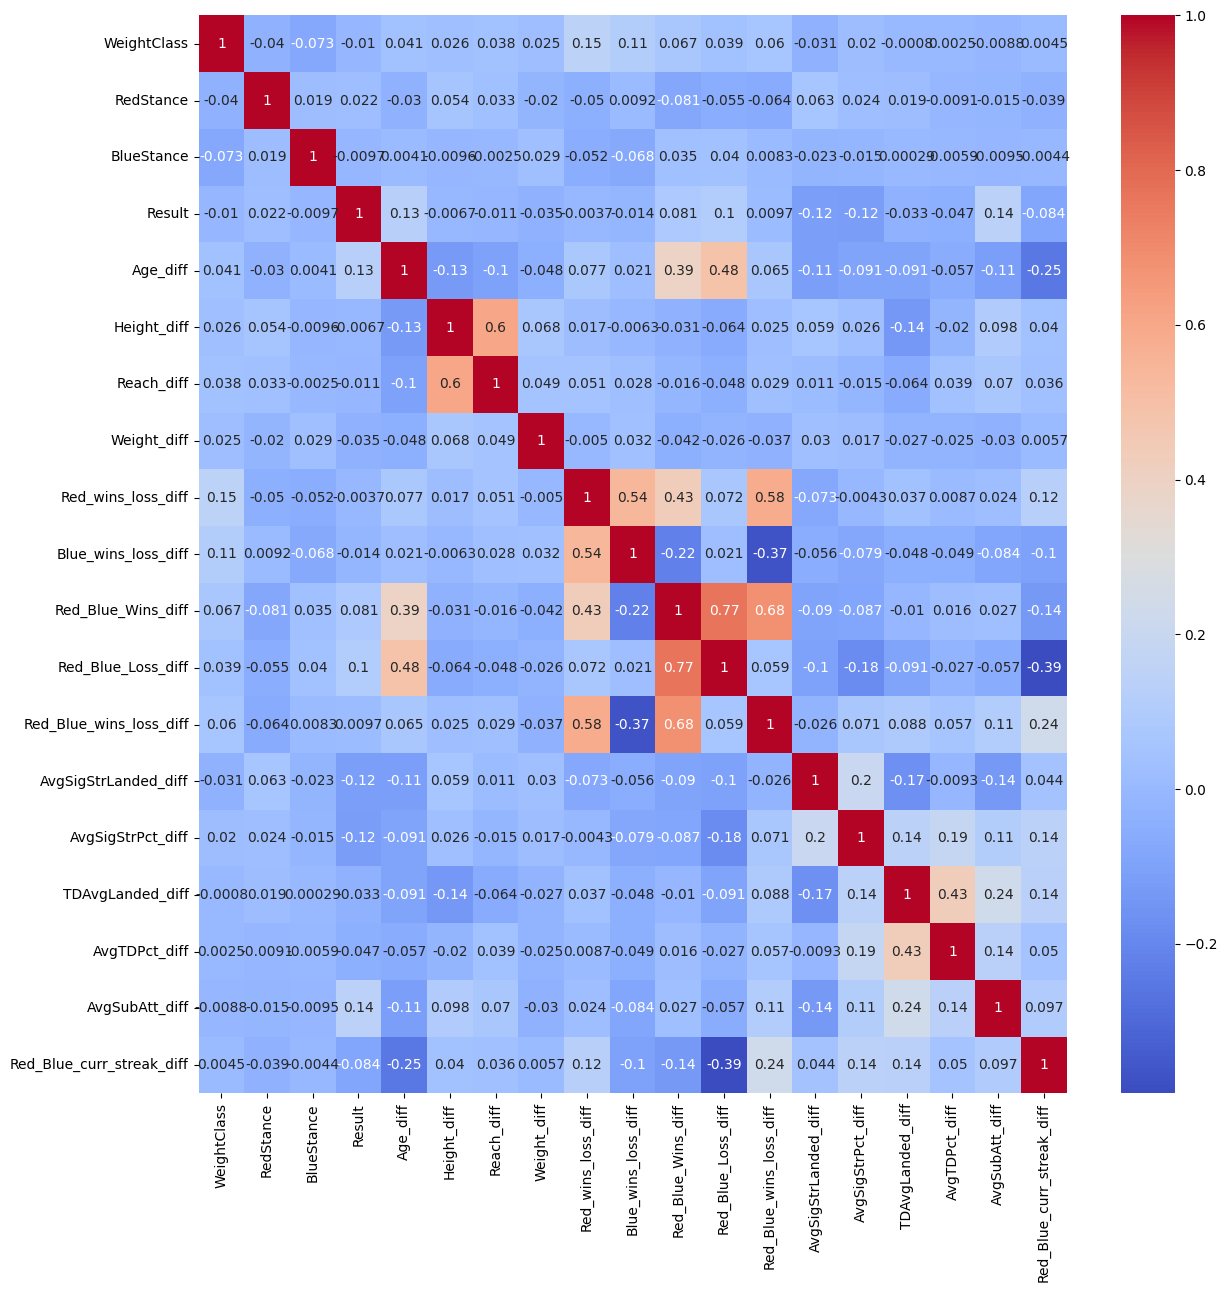

In [492]:
corr_matrix = data_featured_to_export.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [493]:
X = data_featured.drop(columns=['BlueFighter','RedFighter', 'Result'], axis=1)

test_size = 200

X_train_featured = X.iloc[test_size:, :]
y_train = data_featured.iloc[test_size:, 5]

X_test_featured = X.iloc[:test_size, :]
y_test = data_featured.iloc[:test_size, 5]

In [494]:
y_train

218     0
219     1
220     1
221     0
222     1
       ..
2291    0
2293    1
2295    1
2296    0
2297    0
Name: Result, Length: 1821, dtype: int64

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&M

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       113
           1       0.58      0.62      0.60        87

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.64      0.64      0.64       200



Text(0.5, 23.52222222222222, 'predicted value')

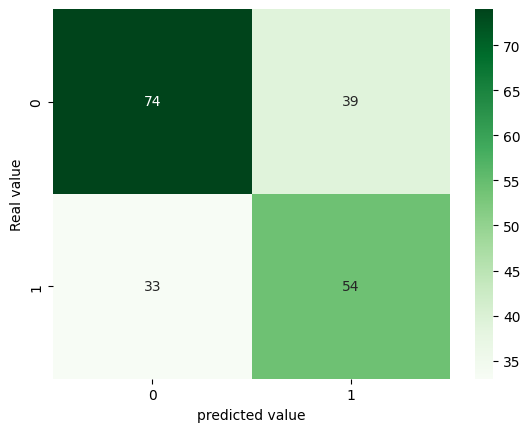

In [495]:
# Обучаем pipeline на тренировочных данных
gs_binary.fit(X_train_featured, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_binary.predict(X_test_featured)

# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [ ]:
pipeline, y_pred, y_proba, model = optimize_and_train(X_train_featured, y_train, X_test_featured, y_test, n_trials=25)

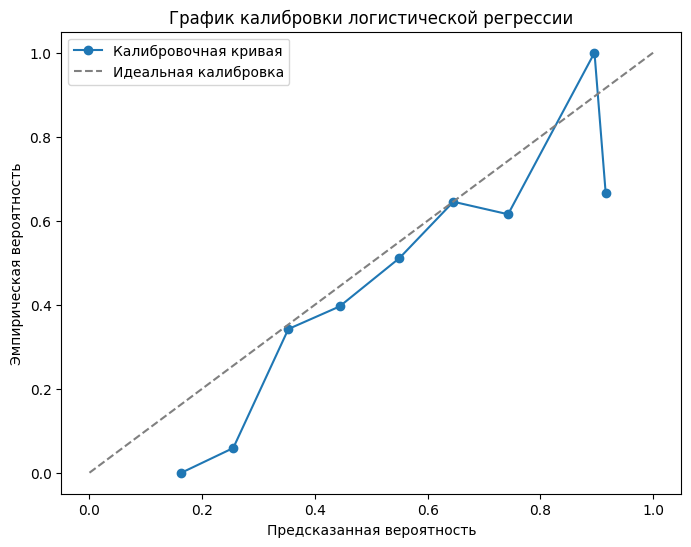

In [496]:
# Предсказание вероятностей
y_proba = gs_binary.predict_proba(X_test_featured)

# Калибровочная кривая
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Эмпирическая вероятность')
plt.title('График калибровки логистической регрессии')
plt.legend()

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       113
           1       0.62      0.60      0.61        87

    accuracy                           0.67       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.66      0.67      0.66       200



Text(0.5, 23.52222222222222, 'predicted value')

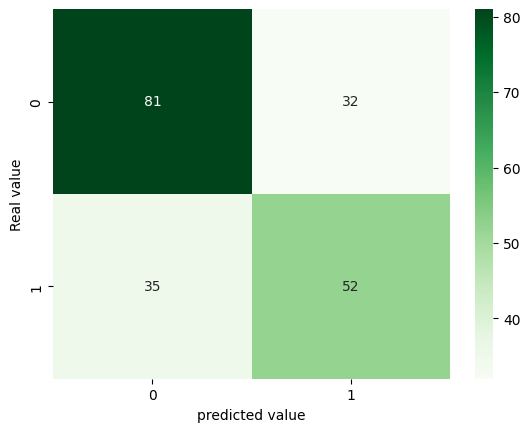

In [497]:
model = gs_binary.best_estimator_
# Предсказываем вероятности
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
calibrated_model.fit(X_test_featured, y_test)
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test_featured)[:, 1]
# # Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, calibrated_proba, n_bins=10, strategy="uniform")

y_pred_calibrated = calibrated_model.predict(X_test_featured)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_calibrated),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [437]:
len(y_proba)

656

In [498]:
# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': data_final['RedFighter'].iloc[:test_size],
    'BlueFighter': data_final['BlueFighter'].iloc[:test_size],
    'ProbabilityRedWins': y_proba [:, 0],
    'ProbabilityBlueWins': y_proba [:, 1],
    'ActualWinner': data_final['Result'].iloc[:test_size]
})

results_df['Predicted_Winner'] = (results_df['ProbabilityBlueWins'] > results_df['ProbabilityRedWins']).astype(int)
results_df['Prediction_Errors'] = np.abs(results_df['Predicted_Winner'] - results_df['ActualWinner'])
results_df.iloc[:30, :]

,RedFighter,BlueFighter,ProbabilityRedWins,ProbabilityBlueWins,ActualWinner,Predicted_Winner,Prediction_Errors
1,Shavkat Rakhmonov,Ian Machado Garry,0.273780,0.726220,0,1,1
2,Ciryl Gane,Alexander Volkov,0.476887,0.523113,0,1,1
3,Bryce Mitchell,Kron Gracie,0.589466,0.410534,0,0,0
4,Nate Landwehr,Dooho Choi,0.441239,0.558761,1,1,0
5,Dominick Reyes,Anthony Smith,0.690262,0.309738,0,0,0
6,Vicente Luque,Themba Gorimbo,0.396711,0.603289,1,1,0
7,Movsar Evloev,Aljamain Sterling,0.701962,0.298038,0,0,0
8,Randy Brown,Bryan Battle,0.442001,0.557999,1,1,0
9,Chris Weidman,Eryk Anders,0.381121,0.618879,1,1,0
10,Cody Durden,Joshua Van,0.275689,0.724311,1,1,0


In [380]:
featured_stats_columns = ['RedSigStrikesAverage',
                          'BlueSigStrikesAverage',
                          'RedSuccesfullTDAverage',
                          'BlueSuccesfullTDAverage',
                          'Red_Blue_SigStrikAvg_diff',
                          'Red_Blue_SuccTDAvg_diff',
                          'Red_Blue_AvgSubAtt_diff']